#### What is Parallelization in LangGraph?
In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don’t depend on each other’s outputs, you can run them in parallel. This is achieved by:
- Defining multiple nodes that can operate independently.

- Connecting them to a common starting point (e.g., START or another node).

- Merging their outputs into a downstream node if needed.

LangGraph handles this implicitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g., Python’s asyncio or a multi-threaded executor).

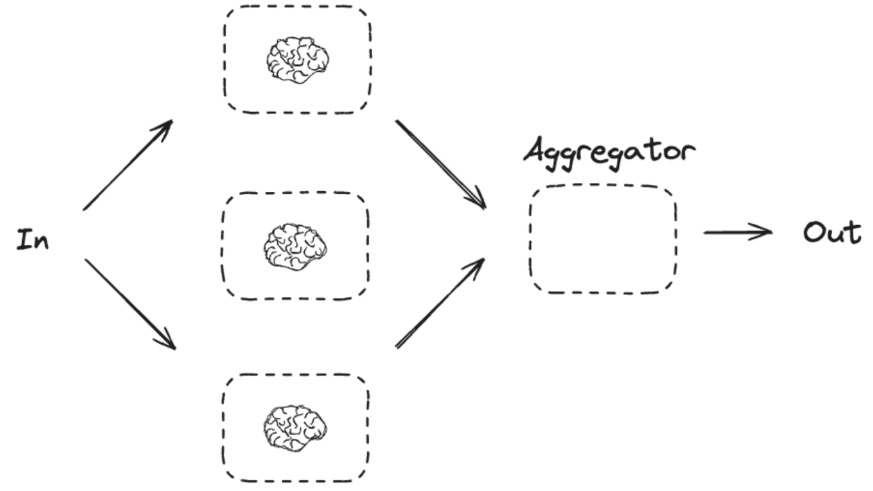

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="openai/gpt-oss-20b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I help you today?', additional_kwargs={'reasoning_content': 'User says "Hello". We need to respond in a friendly way. The user hasn\'t asked a question, so we can greet back.'}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 72, 'total_tokens': 118, 'completion_time': 0.042850056, 'prompt_time': 0.006403692, 'queue_time': 1.514008126, 'total_time': 0.049253748}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_ebaf47239f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--be4ed7fc-f87e-4017-83c6-e441d809c4d0-0', usage_metadata={'input_tokens': 72, 'output_tokens': 46, 'total_tokens': 118})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    topic: str
    characters: str
    settings: str
    premises: str
    story_intro: str

In [4]:
# Nodes
def generate_characters(state: State):
    """Generate character descriptions"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"characters": msg.content}

def generate_setting(state: State):
    """Generate a story setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {"settings": msg.content}

def generate_premise(state: State):
    """Generate a story premise"""
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about {state['topic']}")
    return {"premises": msg.content}

def combine_elements(state: State):
    """Combine characters, setting, and premise into an intro"""
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['characters']}\n"
        f"Setting: {state['settings']}\n"
        f"Premise: {state['premises']}"
    )
    return {"story_intro": msg.content}

In [6]:
# Build the graph
graph = StateGraph(State)
graph.add_node("character", generate_characters)
graph.add_node("setting", generate_setting)
graph.add_node("premise", generate_premise)
graph.add_node("combine", combine_elements)

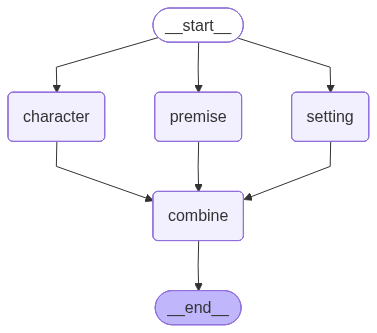

In [7]:
# Define edges (parallel execution from START)
graph.add_edge(START, "character")
graph.add_edge(START, "setting")
graph.add_edge(START, "premise")
graph.add_edge("character", "combine")
graph.add_edge("setting", "combine")
graph.add_edge("premise", "combine")
graph.add_edge("combine", END)

# Compile and run
compiled_graph = graph.compile()
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [8]:
state = {"topic": "time travel"}
result = compiled_graph.invoke(state)
print(result["story_intro"])

The first thing you notice when you slip beneath the rumbling heart of New York is the way the world slows. The screech of trains becomes a low, metallic lullaby, and the air tastes of iron and ozone, a sweet tang that smells like a storm that never came. The tunnels stretch in a maze of rusted steel and cracked concrete, the walls pulsing with phosphorescent fungi that glow in time with the underground heartbeat. It is a place where the present, the past, and the future are not separate but interwoven, a living organism that hums with the promise of paradox.

At the far end of a long, narrow passageway, a door of wrought iron and brass stands alone. Its surface is etched with swirling gears and runes that shift when you look at them too long, as if the symbols themselves were alive. The door creaks open on its own, revealing a cavern that feels both ancient and impossibly modern. Massive brass gears, each the size of a car, turn slowly, their teeth grinding against one another with a 

#### Key Benefits
- Speed: Reduces total execution time by running tasks concurrently.

- Scalability: Handles larger workflows efficiently.

- Modularity: Keeps the graph structure clean and reusable.

#### Key Takeaways
- When to Parallelize: Use it for independent tasks (e.g., generating multiple outputs, checking separate inputs).

- Merging: Downstream nodes can aggregate parallel results.

- LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding.

